In [50]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster,dendrogram,linkage
import itertools

In [2]:
# Load iris dataset and seperate it to features and labels
iris = datasets.load_iris()
irisX = iris.data
irisY = iris.target

In [104]:
# Load breast cancer dataset and seperate it to features and labels
breastC = datasets.load_breast_cancer()
breastX = breastC.data
breastY = breastC.target

In [4]:
# Load optidigits dataset and seperate it to features and labels
optidigits = datasets.load_digits()
optidigitsX = optidigits.data
optidigitsY = optidigits.target

In [5]:
# Load yeast dataset and seperate it to features and labels
yeastTxt = open("yeast.data", "r")
yeastLines = yeastTxt.readlines()
firstData = []
trainData = []
lastData = []
for line in yeastLines:
    line = line.replace("\n", "")
    split = line.split("  ")
    firstData.append(split[0])
    lastData.append(split[-1])
    trainData.append([split[1], split[2], split[3], split[4], split[5], split[6], split[7], split[8]])
    
yeastFirst = np.asarray(firstData)
yeastX = np.asarray(trainData)
yeastLast = np.asarray(lastData)

In [6]:
# creating coassociation matrix 
def create_coassociation_matrix(labels):
    rows = []
    cols = []
    unique_labels = set(labels)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        for index1 in indices:
            for index2 in indices:
                rows.append(index1)
                cols.append(index2)
                
    data = np.ones((len(rows),))
    return csr_matrix((data, (rows, cols)), dtype='float')

In [97]:
def _generate_similarity_mat(labels):
    l_mat = np.repeat(np.asarray(labels).reshape(-1,1), len(labels), axis=1)
    l_mat_t = l_mat.T

    sim_mat = np.equal(l_mat, l_mat_t).astype(int)
    return sim_mat


def overall_quality(y,y_hat):
    return np.mean(y == y_hat) * 100 


# Class of Evidence Accumulation Cluster which has different kind of clustering algorithm
# such as kmeans single link and average link methods
class EAC(BaseEstimator, ClusterMixin):
    def __init__(self, parameters, parameters_SC, use_lifetime = False, n_clusters=3,cut_threshold=0.5):
        self.cut_threshold = cut_threshold
        self.use_lifetime = use_lifetime
        self.n_clusters = n_clusters
        self.parameters = parameters
        self.parameters_SC = parameters_SC
    def fit(self, X, y=None, method = None):
        coassociation_algorithms = []
        for i in self.parameters:
            coassociation_algorithms.append(create_coassociation_matrix(self._kmeans_clustering(X,i)))
            coassociation_algorithms.append(create_coassociation_matrix(self._singleLink_clustering(X,i)))
        for i in self.parameters_SC:
            coassociation_algorithms.append(create_coassociation_matrix(self._spectral_clustering(X, i)))
        
        C = sum(coassociation_algorithms)
        
        # get the average of the similarity mat
        avgC = np.divide(C.toarray(), (len(self.parameters)*2 + len(self.parameters_SC)))

        # flip the similarity. smaller value implies more similarity
        avgC = np.abs(np.max(avgC) - avgC)

        # build clusters
        self.Z_ = linkage(avgC, method="single")
        
        # Calculate the number of clusters using cluster lifetime from the dendrogram
        # The longest lifetime is choosen as number of cluster.
        self.dn = dendrogram(self.Z_, no_plot = True )
        if self.use_lifetime:
            distance_set = set()
            for i in self.dn['dcoord']:
                distance_set = distance_set.union(set(i))
            distances = list(distance_set)
            distances.sort(reverse=True)
            lifetime_dict = {}
            k = 2
            for i in range(len(distances)-1):
                lifetime_dict[k] = distances[i] - distances[i+1]
                k += 1
            self.n_clusters = sorted(lifetime_dict.items(), key=lambda x: x[1], reverse=True)[0][0]

        self.labels_ = fcluster(self.Z_, self.n_clusters, criterion='maxclust')
        
        """
        mst = minimum_spanning_tree(-C)
        mst.data[mst.data > -self.cut_threshold] = 0
        self.n_components, self.labels_ = connected_components(mst)
        self.coassociation_matrix = coassociation_algorithms
        """
        return self

    def _kmeans_clustering(self, X, k):
        km = KMeans(n_clusters=k)
        return km.fit_predict(X)
    
    def _averageLink_clustering(self, X, k):
        alCluster = AgglomerativeClustering(n_clusters = k, linkage = "average")
        alCluster.fit(X)
        return alCluster.labels_
    
    def _singleLink_clustering(self, X, k):
        slCluster = AgglomerativeClustering(n_clusters = k, linkage = "single")
        slCluster.fit(X)
        return slCluster.labels_
    
    def _spectral_clustering(self, X, parameters):
        sc = SpectralClustering(n_clusters=parameters[0])
        return sc.fit_predict(X)

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [25.0, 25.0, 42.5, 42.5],
  [10.0, 10.0, 33.75, 33.75]],
 'dcoord': [[0.0, 138.0, 138.0, 0.0],
  [0.0, 219.0, 219.0, 0.0],
  [0.0, 255.0, 255.0, 219.0],
  [0.0, 268.0, 268.0, 255.0],
  [138.0, 295.0, 295.0, 268.0]],
 'ivl': ['2', '5', '1', '0', '3', '4'],
 'leaves': [2, 5, 1, 0, 3, 4],
 'color_list': ['g', 'b', 'b', 'b', 'b']}

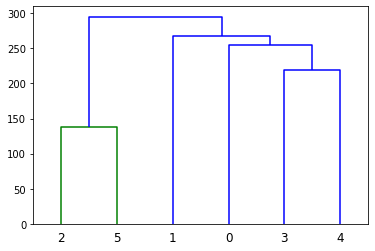

In [121]:
ytdist = np.array([662., 877., 255., 412., 996., 295., 468., 268.,
                   400., 754., 564., 138., 219., 869., 669.])
Z = linkage(ytdist, 'single')
plt.figure()
dn = dendrogram(Z)
distance_set = set()
for i in dn['dcoord']:
    distance_set = distance_set.union(set(i))
distances = list(distance_set)
distances.sort(reverse=True)
lifetime_dict = {}
k = 2
for i in range(len(distances)-1):
    lifetime_dict[k] = distances[i] - distances[i+1]
    k += 1
lifetime_dict
k = sorted(lifetime_dict.items(), key=lambda x: x[1], reverse=True)[0][0]
labels= fcluster(Z,t=k)
dn

In [130]:
len(dn['leaves'])
print(dn['leaves'])
print(dn['ivl'])

[41, 22, 35, 47, 45, 42, 38, 34, 30, 29, 25, 13, 12, 9, 8, 6, 3, 1, 2, 33, 32, 18, 16, 15, 14, 5, 10, 49, 43, 40, 39, 37, 31, 28, 27, 26, 24, 23, 21, 20, 17, 11, 7, 0, 4, 48, 46, 44, 19, 36, 106, 98, 93, 57, 60, 117, 131, 102, 129, 130, 107, 125, 111, 137, 132, 128, 103, 116, 147, 145, 141, 139, 110, 112, 115, 148, 144, 143, 140, 136, 124, 120, 100, 104, 68, 87, 114, 52, 77, 62, 72, 119, 149, 146, 142, 138, 133, 127, 126, 123, 121, 113, 101, 70, 83, 97, 85, 91, 86, 76, 75, 65, 58, 56, 54, 50, 51, 74, 63, 73, 78, 66, 55, 61, 59, 92, 89, 82, 81, 80, 79, 69, 67, 53, 64, 71, 99, 96, 95, 94, 90, 84, 88, 134, 108, 122, 105, 118, 109, 135]
['41', '22', '35', '47', '45', '42', '38', '34', '30', '29', '25', '13', '12', '9', '8', '6', '3', '1', '2', '33', '32', '18', '16', '15', '14', '5', '10', '49', '43', '40', '39', '37', '31', '28', '27', '26', '24', '23', '21', '20', '17', '11', '7', '0', '4', '48', '46', '44', '19', '36', '106', '98', '93', '57', '60', '117', '131', '102', '129', '130', '1

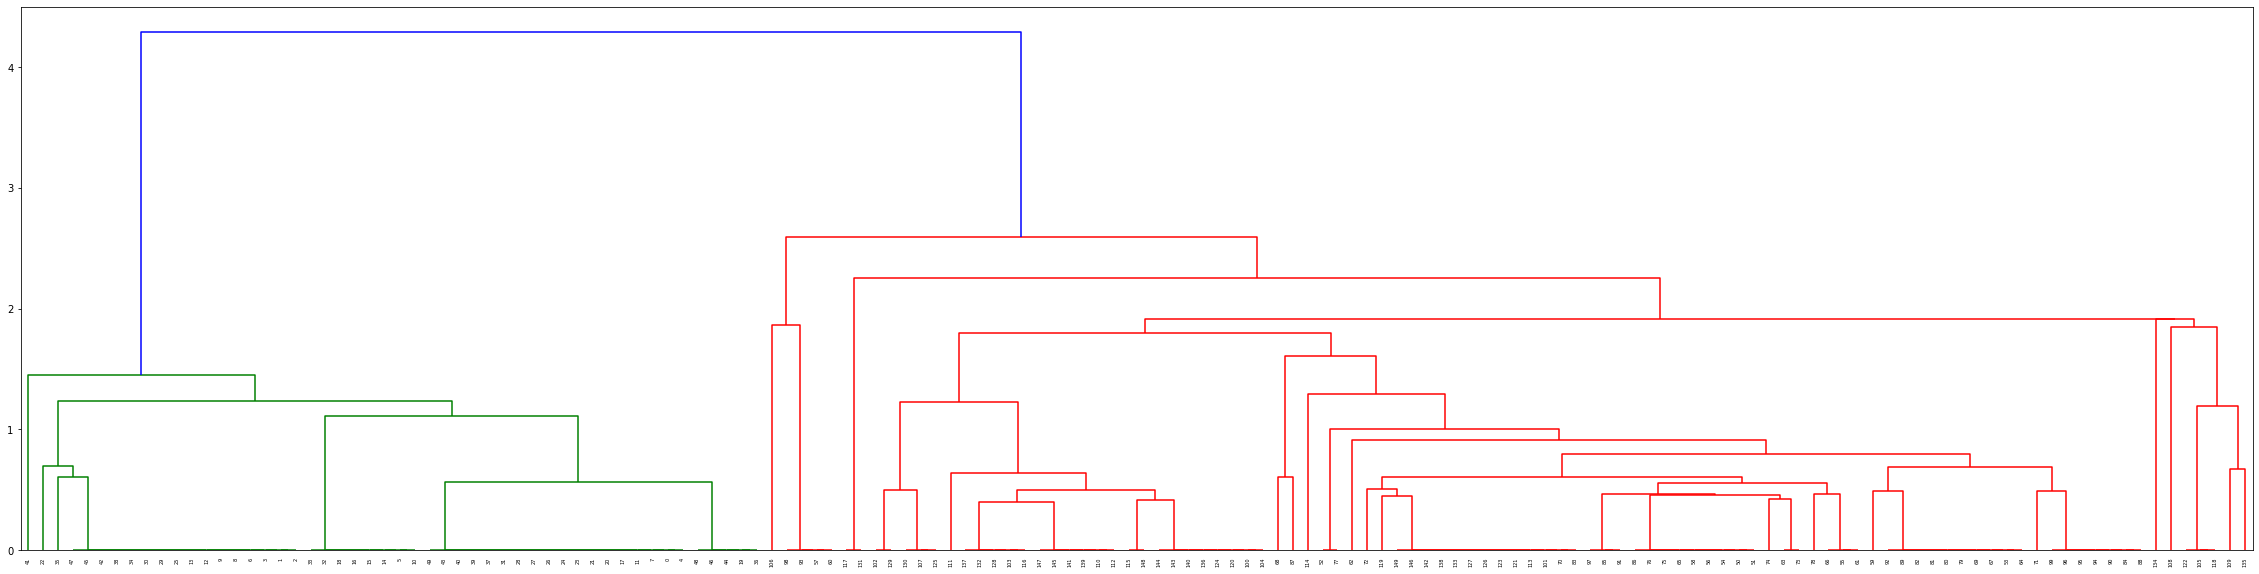

In [133]:
eac1.Z_.shape
fig = plt.figure(figsize=(40, 10))
dn = dendrogram(eac1.Z_, get_leaves=True)
plt.show()
distance_set = set()
for i in dn['dcoord']:
    distance_set = distance_set.union(set(i))
distances = list(distance_set)
distances.sort(reverse=True)
lifetime_dict = {}
k = 2
for i in range(len(distances)-1):
    lifetime_dict[k] = distances[i] - distances[i+1]
    k += 1
lifetime_dict
k = sorted(lifetime_dict.items(), key=lambda x: x[1], reverse=True)[0][0]

In [134]:
dn

{'icoord': [[175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [155.0, 155.0, 172.5, 172.5],
  [145.0, 145.0, 163.75, 163.75],
  [135.0, 135.0, 154.375, 154.375],
  [125.0, 125.0, 144.6875, 144.6875],
  [115.0, 115.0, 134.84375, 134.84375],
  [105.0, 105.0, 124.921875, 124.921875],
  [95.0, 95.0, 114.9609375, 114.9609375],
  [85.0, 85.0, 104.98046875, 104.98046875],
  [75.0, 75.0, 94.990234375, 94.990234375],
  [65.0, 65.0, 84.9951171875, 84.9951171875],
  [55.0, 55.0, 74.99755859375, 74.99755859375],
  [45.0, 45.0, 64.998779296875, 64.998779296875],
  [35.0, 35.0, 54.9993896484375, 54.9993896484375],
  [25.0, 25.0, 44.99969482421875, 44.99969482421875],
  [15.0, 15.0, 34.999847412109375, 34.999847412109375],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [235.0, 235.0, 252.5, 252.5],
  [225.0, 225.0, 243.75, 243.75],
  [215.0, 215.0, 234.375, 234.375],
  [205.0, 205.0, 224.6875, 224.6875],
  [195.0, 195.0, 214.84375, 214.84375],
  [435.0, 435.0, 445.0, 

In [101]:
# For iris dataset
k = [3,5,10,12,15]
parameters_SC = []
eac1 = EAC(k, parameters_SC, cut_threshold=0.9)
eac1.fit(irisX)
print(overall_quality(irisY, (eac1.labels_ - 1)))
eac1.labels_ -1

68.66666666666667


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [100]:
# For iris dataset
k = [3,5,10,12,15]
parameters_SC = []
eac1 = EAC(k, parameters_SC, use_lifetime=True, cut_threshold=0.9)
eac1.fit(irisX)
print(overall_quality(irisY, (eac1.labels_ - 1)))
eac1.labels_ -1

66.66666666666666


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [102]:
# For iris dataset
k = [3,5,10,12,15]
parameters_SC = [(3,0.1), (12,0.1)]
eac2 = EAC(k, parameters_SC, cut_threshold=0.1)
eac2.fit(irisX)
print(overall_quality(irisY, (eac2.labels_ - 1)))
(eac2.labels_ - 1)

68.66666666666667


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [103]:
# For iris dataset
k = [3,5,10,12,15]
parameters_SC = [(3,0.1), (12,0.1)]
eac2 = EAC(k, parameters_SC, use_lifetime=True, cut_threshold=0.1)
eac2.fit(irisX)
print(overall_quality(irisY, (eac2.labels_ - 1)))
(eac2.labels_ - 1)

66.66666666666666


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [34]:
# For Breast-C dataset
k = [2, 3, 5, 10]
parameters_SC = []
eac3 = EAC(k, parameters_SC, cut_threshold = 0.5)
eac3.fit(breasX)
print(overall_quality(breasY, np.abs(eac3.labels_ - 2)))
eac3.labels_
breasY

62.91739894551846


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [ ]:
# -*- coding: utf-8 -*-
"""Combining multiple clusterings using evidence accumulation (EAC).
"""
# Author: Yue Zhao <zhaoy@cmu.edu>
# License: BSD 2 clause

import warnings
import numpy as np

from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted

from pyod.utils.utility import check_parameter

from .base import BaseAggregator


def _generate_similarity_mat(labels):
    l_mat = np.repeat(labels, len(labels), axis=1)
    l_mat_t = l_mat.T

    sim_mat = np.equal(l_mat, l_mat_t).astype(int)
    return sim_mat

def overall_quality(y,y_hat):
    return np.mean(y == y_hat) * 100 


class EAC(BaseAggregator):

    def __init__(self, base_estimators, n_clusters, linkage_method='single',
                 weights=None, pre_fitted=False):

        super(EAC, self).__init__(
            base_estimators=base_estimators, pre_fitted=pre_fitted)

        check_parameter(n_clusters, low=2, param_name='n_clusters')
        self.n_clusters = n_clusters

        # set estimator weights
        self._set_weights(weights)

        self.linkage_method = linkage_method

    def fit(self, X):
        # Validate inputs X
        X = check_array(X)
        n_samples = X.shape[0]

        # initialize similarity matrix
        sim_mat_all = np.zeros([n_samples, n_samples])

        if self.pre_fitted:
            print("Training Skipped")

        else:
            for clf in self.base_estimators:
                clf.fit(X)
                clf.fitted_ = True

        for i, estimator in enumerate(self.base_estimators):
            check_is_fitted(estimator, ['labels_'])

            # get the labels from each base estimator
            labels = estimator.labels_.reshape(n_samples, 1)

            # generate the similarity matrix for the current estimator
            sim_mat = _generate_similarity_mat(labels)

            # add to the main similarity mat
            sim_mat_all = sim_mat_all + sim_mat

        # get the average of the similarity mat
        sim_mat_avg = np.divide(sim_mat_all, self.n_base_estimators_)

        # flip the similarity. smaller value implies more similarity
        sim_mat_avg = np.abs(np.max(sim_mat_avg) - sim_mat_avg)

        # build clusters
        self.Z_ = linkage(sim_mat_avg, method=self.linkage_method)
        self.labels_ = fcluster(self.Z_, self.n_clusters, criterion='maxclust')

        # it may leads to different number of clusters as specified by the user
        if len(np.unique(self.labels_)) != self.n_clusters:
            warnings.warn(
                'EAC generates {n} clusters instead of {n_clusters}'.format(
                    n=len(np.unique(self.labels_)),
                    n_clusters=self.n_clusters))

        return self

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_